In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [5]:
def load_and_prepare_data():
    """Загружает данные, разделяет их на обучающую и тестовую выборки и масштабирует."""
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_and_prepare_data()

In [6]:
def apply_pca(X_train, X_test, n_components=2):
    """Применяет PCA к данным для уменьшения размерности."""
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test)

In [7]:
def plot_decision_boundaries(model, X_train, y_train, title):
    """Строит границы принятия решений для модели."""
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(7, 7))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.5, cmap="coolwarm")
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title(title)
    plt.colorbar(label='Class')
    plt.show()

In [8]:
def evaluate_model(model, X_test, y_test, model_name):
    """Оценивает модель по метрикам ROC AUC и F1."""
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, model.predict(X_test))
    print(f"{model_name}: ROC AUC: {auc}, F1: {f1}")

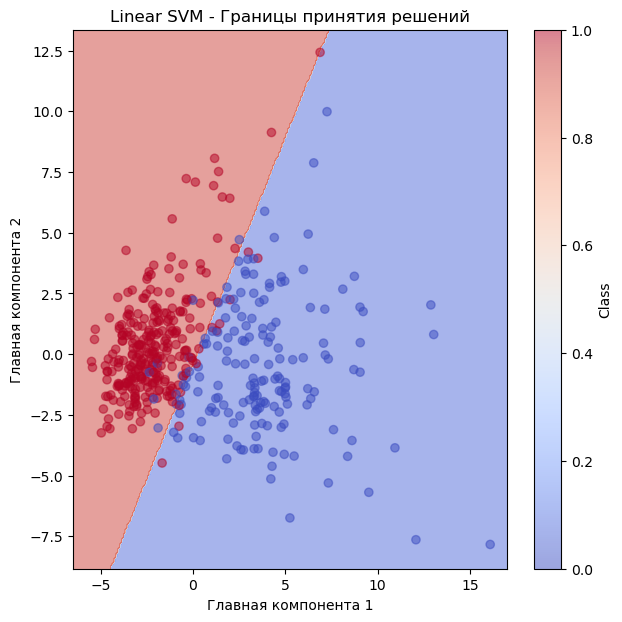

SVM с ядром 'linear': ROC AUC: 0.998689813298395, F1: 0.993006993006993


In [9]:
# Обучение и оценка SVM с линейным ядром
svm_linear_pca = SVC(kernel="linear", probability=True)
svm_linear_pca.fit(X_train_pca, y_train)

plot_decision_boundaries(svm_linear_pca, X_train_pca, y_train, 'Linear SVM - Границы принятия решений')
evaluate_model(svm_linear_pca, X_test_pca, y_test, "SVM с ядром 'linear'")

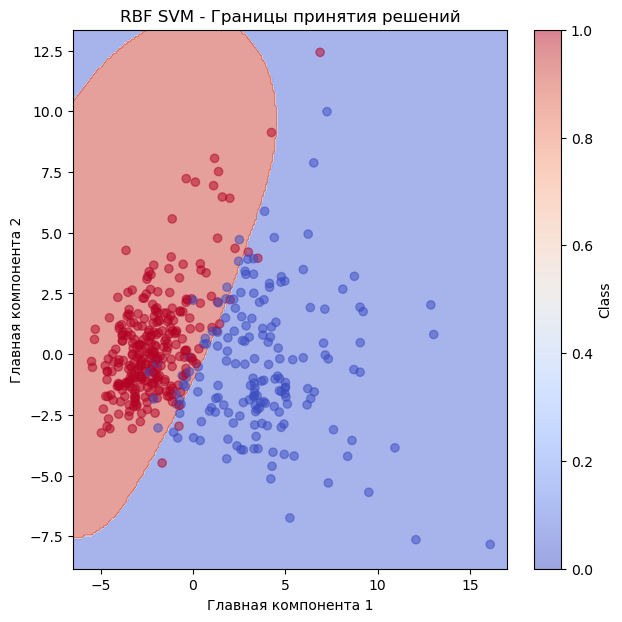

SVM с ядром 'rbf': ROC AUC: 0.99737962659679, F1: 0.9861111111111112


In [10]:
# Обучение и оценка SVM с RBF-ядром
svm_rbf = SVC(kernel="rbf", probability=True)
svm_rbf.fit(X_train, y_train)

# Создание сетки точек для визуализации границ принятия решений
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Преобразование точек сетки обратно в исходное пространство признаков
meshgrid_original = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
Z = svm_rbf.predict(meshgrid_original).reshape(xx.shape)

plt.figure(figsize=(7, 7))
plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, alpha=0.5, cmap="coolwarm")
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('RBF SVM - Границы принятия решений')
plt.colorbar(label='Class')
plt.show()

evaluate_model(svm_rbf, X_test, y_test, "SVM с ядром 'rbf'")

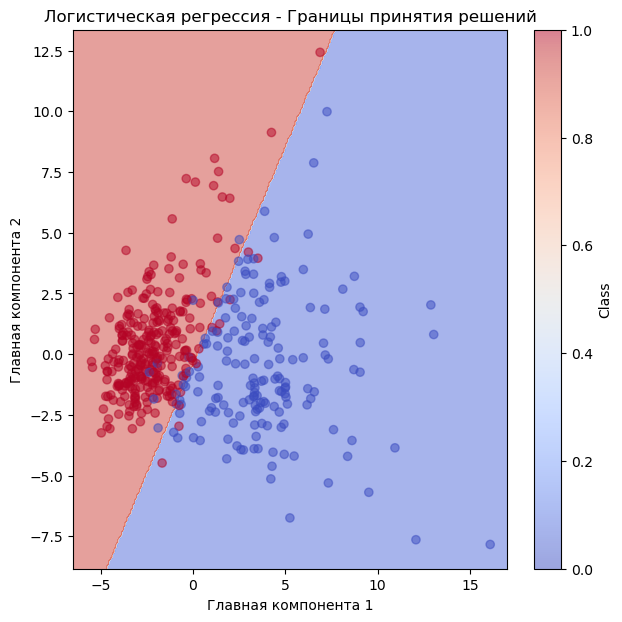

Логистическая регрессия: ROC AUC: 0.998689813298395, F1: 0.993006993006993


In [11]:
# Обучение и оценка логистической регрессии
logreg_pca = LogisticRegression(max_iter=10000)
logreg_pca.fit(X_train_pca, y_train)

plot_decision_boundaries(logreg_pca, X_train_pca, y_train, 'Логистическая регрессия - Границы принятия решений')
evaluate_model(logreg_pca, X_test_pca, y_test, "Логистическая регрессия")

Полиномиальная логистическая регрессия: ROC AUC: 0.9921388797903701, F1: 0.9577464788732394


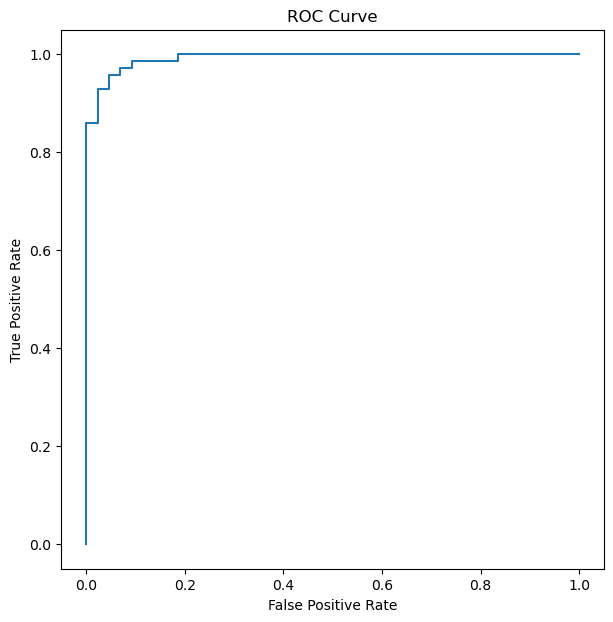

In [12]:
# Обучение и оценка полиномиальной логистической регрессии
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg_poly = LogisticRegression(max_iter=10000)
logreg_poly.fit(X_train_poly, y_train)

y_pred_proba = logreg_poly.predict_proba(X_test_poly)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, logreg_poly.predict(X_test_poly))
print(f"Полиномиальная логистическая регрессия: ROC AUC: {auc}, F1: {f1}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [13]:
# Обучение и оценка k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"k-ближайшие соседи: ROC AUC: {roc_auc}, F1: {f1}")

k-ближайшие соседи: ROC AUC: 0.9369472649852605, F1: 0.950354609929078
